In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_iris
from matplotlib.colors import LightSource
from tabulate import tabulate
from time import perf_counter
from sklearn.datasets import load_breast_cancer
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import train_test_split
from time import perf_counter
from sklearn.preprocessing import LabelBinarizer
import random
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
import tensorflow_addons as tfa
import sklearn
from statsmodels.stats.proportion import proportion_confint

/home/logongas/Documentos/desarrollo/python_default_env/.venv/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
#Funciones de gráficas


def axes_configure_for_metrics(axes,title,xlabel,ylabel,color="#003B80",facecolor="#FAFCFF",gridcolor="#BAD4F2",legend=True):
    axes.set_xlabel(xlabel, fontsize=13,color=color)
    axes.set_ylabel(ylabel, fontsize=13,color=color)
    axes.set_title(title,color=color)


    axes.set_xlim(xmin=0,xmax=1)
    axes.set_ylim(ymin=0,ymax=1.1)

    axes.xaxis.set_major_locator(MultipleLocator(0.1))
    axes.yaxis.set_major_locator(MultipleLocator(0.1))
    axes.grid(visible=True, which='major', axis='both',color=gridcolor,linewidth=1)
    axes.set_axisbelow(True)
    
    axes.set_facecolor(facecolor)
    axes.spines['bottom'].set_color(color)
    axes.spines['top'].set_color(color)
    axes.spines['right'].set_color(color)
    axes.spines['left'].set_color(color)
    axes.tick_params(axis='both', colors=color)

    if (legend):
        axes.legend()

def plot_metrics(axes,history,title,metric,label):

 
      axes.plot(history[metric],linestyle="dotted",c="#003B80")  
      axes.plot(history[f'val_{metric}'],linestyle="solid",label=f"{label} validación:{history[f'val_{metric}'][-1]:.2f}",c="#003B80")

      axes.set_xlabel('Nº Épocas', fontsize=13,color="#003B80")
      axes.xaxis.set_major_locator(MaxNLocator(integer=True))

      axes.set_ylabel(label, fontsize=13,color="#003B80")
      axes.set_ylim(ymin=0,ymax=1.1)
      axes.yaxis.set_major_locator(MultipleLocator(0.1))

      axes.set_title(title)
      axes.set_facecolor("#F0F7FF")
      axes.grid(visible=True, which='major', axis='both',color="#FFFFFF",linewidth=2)
      axes.legend()


def plot_intervals(axes,intervalos,title,xlabel,ylabels):
    for index, (inferior, superior) in enumerate(intervalos):
        position=len(intervalos)-index-1
        media=((superior-inferior)/2)+inferior
        axes.plot([inferior, superior], [position, position], marker='|', markersize=10, linestyle='-', color='#003B80')
        axes.scatter(media, position, color='#003B80')        
 
    axes.set_yticks(np.arange(len(ylabels)))
    axes.set_yticklabels(ylabels[::-1])
    axes.set_xlabel(xlabel)
    axes.set_title(title)
 
    axes.set_facecolor("#F0F7FF")
    axes.grid(visible=True, which='major', axis='both',color="#FFFFFF",linewidth=1)



def plot_intervals_with_guides(axes,intervalos,title,xlabel,ylabels):
    for index, (inferior, superior) in enumerate(intervalos):
        position=len(intervalos)-index-1
        media=((superior-inferior)/2)+inferior
        color=next(axes._get_lines.prop_cycler)['color']
        axes.plot([inferior, superior], [position, position], marker='|', markersize=10, linestyle='-', color=color)
        axes.scatter(media, position, color=color) 
        axes.plot([inferior, inferior], [0, len(intervalos)-1], linewidth=0.5, linestyle='dashed', color=color)   
        axes.plot([superior, superior], [0, len(intervalos)-1], linewidth=0.5, linestyle='dashed', color=color)
        
    axes.set_yticks(np.arange(len(ylabels)))
    axes.set_yticklabels(ylabels[::-1])
    axes.set_xlabel(xlabel)
    axes.set_title(title)

    axes.set_facecolor("#F0F7FF")
    axes.grid(visible=True, which='major', axis='both',color="#FFFFFF",linewidth=1)



In [3]:
#Funciones de redes neuronales

def compile_fit(capas,activation,last_activation,loss,optimizer,epochs,x_train, x_test, y_train, y_test,metrics=[]):

    input_dim=x_train.shape[1]

    np.random.seed(5)
    tf.random.set_seed(5)
    random.seed(5)
   
    model=Sequential()
    for index,neuronas_capa in enumerate(capas):
        if (index==0):
            model.add(Dense(neuronas_capa, activation=activation,input_dim=input_dim))
        elif (index==len(capas)-1):
            model.add(Dense(neuronas_capa, activation=last_activation))          
        else:
            model.add(Dense(neuronas_capa, activation=activation))

    model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
   
    history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=epochs,verbose=False)

    return history,model


def get_datos(seed=42):
  datos=load_breast_cancer()
  x=datos.data
  y=datos.target

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed,stratify=y)

  return x_train, x_test, y_train, y_test    


def specificity(y_true, y_score):
    threshold=0.5
    y_pred = tf.cast(tf.greater(y_score, threshold), tf.float32)
 
 
    true_negatives = tf.logical_and(tf.equal(y_true, 0), tf.equal(y_pred, 0))
    num_true_negatives=tf.reduce_sum(tf.cast(true_negatives, tf.float32))
 
 
    negatives =tf.equal(y_true, 0)
    num_negatives= tf.reduce_sum(tf.cast(negatives, tf.float32))
 
 
    specificity = num_true_negatives / (num_negatives + tf.keras.backend.epsilon())
     
    return specificity

In [4]:
#Funciones de métricas

def div_not_nan(a,b):
    if (b==0):
        return 0
    else:
        return a/b
    

def get_matriz_confusion(y_true,y_score,threshold):

    y_pred=y_score>threshold

    TP=sum((y_true==1) & (y_pred==1))
    TN=sum((y_true==0) & (y_pred==0))
    FP=sum((y_true==0) & (y_pred==1))
    FN=sum((y_true==1) & (y_pred==0))


    return TP,TN,FP,FN


def get_sensibilidad_with_interval(TP,TN,FP,FN,confidence=0.95):
    success=TP
    total=TP+FN

    sensibilidad=div_not_nan(success,total)
    sensibilidad_lower,sensibilidad_upper=proportion_confint(success,total,method="jeffreys",alpha=1-confidence)

    return sensibilidad,sensibilidad_lower,sensibilidad_upper

def get_especificidad_with_interval(TP,TN,FP,FN,confidence=0.95):
    success=TN
    total=TN+FP

    especificidad=div_not_nan(success,total)
    especificidad_lower,especificidad_upper=proportion_confint(success,total,method="jeffreys",alpha=1-confidence)

    return  especificidad,especificidad_lower,especificidad_upper



def get_threshold_sensibilidad_especificidad(y_true,y_score,confidence=0.95):
    rango_threshold=np.linspace(0,1,500)
    rango_sensibilidad=[]
    rango_especificidad=[]
    rango_sensibilidad_lower=[]
    rango_especificidad_lower=[]
    rango_sensibilidad_upper=[]
    rango_especificidad_upper=[]    



    for threshold in rango_threshold:
        TP,TN,FP,FN=get_matriz_confusion(y_true,y_score,threshold=threshold)

        sensibilidad,sensibilidad_lower,sensibilidad_upper=get_sensibilidad_with_interval(TP,TN,FP,FN,confidence)
        rango_sensibilidad.append(sensibilidad)
        rango_sensibilidad_lower.append(sensibilidad_lower)
        rango_sensibilidad_upper.append(sensibilidad_upper)


        especificidad,especificidad_lower,especificidad_upper=get_especificidad_with_interval(TP,TN,FP,FN,confidence)
        rango_especificidad.append(especificidad)
        rango_especificidad_lower.append(especificidad_lower)
        rango_especificidad_upper.append(especificidad_upper)


    return  rango_threshold,rango_sensibilidad,rango_sensibilidad_lower,rango_sensibilidad_upper,rango_especificidad,rango_especificidad_lower,rango_especificidad_upper


In [7]:
#Ejercicio 2

print("Especificidad Prospecto = [0,9822 ‑ 0,9999]")
lower, upper = proportion_confint(310, 311, alpha=1-(95/100), method="beta")
print(f"Especificidad Calculado = [{lower:.4f} - {upper:.4f}]")

Especificidad Prospecto = [0,9822 ‑ 0,9999]
Especificidad Calculado = [0.9822 - 0.9999]


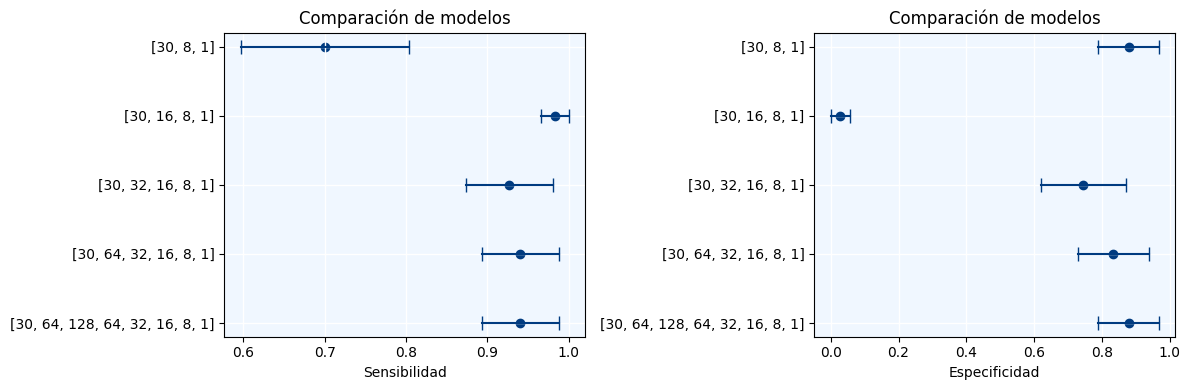

In [10]:
#Ejercicio 3

def get_trained_model(capas,activation,epochs,optimizer,seed=42):
    x_train, x_test, y_train, y_test=get_datos(seed)

    history,model=compile_fit(capas,activation,"sigmoid","binary_crossentropy",optimizer,epochs,x_train, x_test, y_train, y_test)

    return history,model,x_test,y_test


networks=[
    [30,8,1],
    [30,16,8,1],
    [30,32,16,8,1],
    [30,64,32,16,8,1],
    [30,64,128,64,32,16,8,1]    
]

intervalos_sensibilidad=[]
intervalos_especificidad=[]
nombre_modelos=[]

for capas in networks:
    history,model,x_test,y_test=get_trained_model(capas,"ELU",20,tf.keras.optimizers.Adam(learning_rate=0.0001))
    y_score=model.predict(x_test).reshape(-1)
    y_true=y_test
    TP,TN,FP,FN=get_matriz_confusion(y_true,y_score,threshold=0.5)

    sensibilidad,sensibilidad_lower,sensibilidad_upper=get_sensibilidad_with_interval(TP,TN,FP,FN,0.95)
    especificidad,especificidad_lower,especificidad_upper=get_especificidad_with_interval(TP,TN,FP,FN,0.95)

    intervalos_sensibilidad.append([sensibilidad_lower,sensibilidad_upper])
    intervalos_especificidad.append([especificidad_lower,especificidad_upper])
    nombre_modelos.append(str(capas))

figure=plt.figure(figsize=(12, 4)) 
axes=figure.add_subplot(1,2,1)
plot_intervals(axes,intervalos_sensibilidad,"Comparación de modelos","Sensibilidad",nombre_modelos)
axes=figure.add_subplot(1,2,2)
plot_intervals(axes,intervalos_especificidad,"Comparación de modelos","Especificidad",nombre_modelos)

figure.tight_layout()

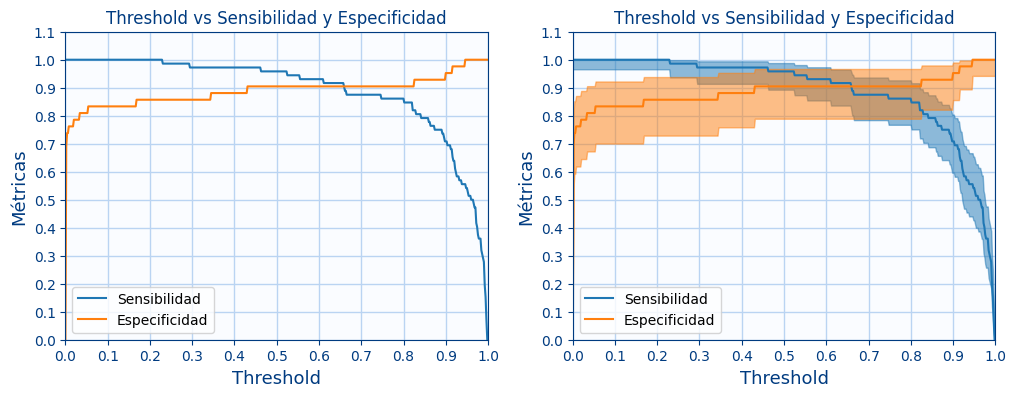

In [11]:
#Ejercicio 4

history,model,x_test,y_test=get_trained_model(networks[4],"ELU",20,tf.keras.optimizers.Adam(learning_rate=0.0001))
y_score=model.predict(x_test).reshape(-1)
y_true=y_test
TP,TN,FP,FN=get_matriz_confusion(y_true,y_score,threshold=0.5)


rango_threshold,rango_sensibilidad,rango_sensibilidad_lower,rango_sensibilidad_upper,rango_especificidad,rango_especificidad_lower,rango_especificidad_upper=get_threshold_sensibilidad_especificidad(y_true,y_score,confidence=0.95)

figure=plt.figure(figsize=(12, 4)) 
axes=figure.add_subplot(1,2,1)

color=next(axes._get_lines.prop_cycler)['color']
axes.plot(rango_threshold,rango_sensibilidad,linestyle="solid",label="Sensibilidad",color=color)
color=next(axes._get_lines.prop_cycler)['color']

axes.plot(rango_threshold,rango_especificidad,linestyle="solid",label="Especificidad",color=color)
axes_configure_for_metrics(axes,"Threshold vs Sensibilidad y Especificidad","Threshold","Métricas")

axes=figure.add_subplot(1,2,2)

color=next(axes._get_lines.prop_cycler)['color']
axes.plot(rango_threshold,rango_sensibilidad,linestyle="solid",label="Sensibilidad",color=color)
axes.fill_between(rango_threshold, rango_sensibilidad_lower, rango_sensibilidad_upper, color=color, alpha=0.5)
color=next(axes._get_lines.prop_cycler)['color']

axes.plot(rango_threshold,rango_especificidad,linestyle="solid",label="Especificidad",color=color)
axes.fill_between(rango_threshold, rango_especificidad_lower,  rango_especificidad_upper, color=color, alpha=0.5)
axes_configure_for_metrics(axes,"Threshold vs Sensibilidad y Especificidad","Threshold","Métricas")
